### Explore locally cached Argo oxygen float data
*Use the oxyfloat module to get data and Pandas to operate on it for testing ability to easily perform calibrations*

First, initialize the default local cache and get the defult list of floats that have oxygen data.

In [1]:
from oxyfloat import OxyFloat
of = OxyFloat()
wmo_list = of.get_oxy_floats_from_status()

We can explore the distribution of AGEs of the Argo floats by getting the status data in a DataFrame (`sdf`). 

In [2]:
sdf = of._get_df(of._STATUS)

Plot the distribution of the AGE column.

Populating the interactive namespace from numpy and matplotlib


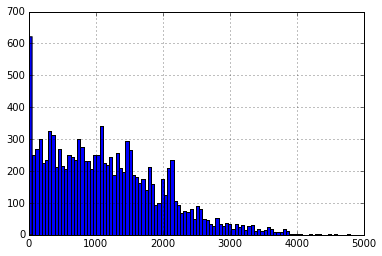

In [3]:
%pylab inline
sdf['AGE'].hist(bins=100)

There are over 600 floats with an AGE of 0. The `.get_oxy_floats_from_status()` method does not select these floats as I believe they are 'inactive'.  Let's count the number of non-greylisted oxygen floats at various AGEs so that we can build a reasonably sized test cache.

In [4]:
print 'Count age_gte 0340:', len(sdf.query('(AGE != 0) & (AGE >= 340) & (OXYGEN == 1) & (GREYLIST != 1)'))
print 'Count age_gte 1000:', len(sdf.query('(AGE != 0) & (AGE >= 1000) & (OXYGEN == 1) & (GREYLIST != 1)'))
print 'Count age_gte 2000:', len(sdf.query('(AGE != 0) & (AGE >= 2000) & (OXYGEN == 1) & (GREYLIST != 1)'))
print 'Count age_gte 2200:', len(sdf.query('(AGE != 0) & (AGE >= 2200) & (OXYGEN == 1) & (GREYLIST != 1)'))

Count age_gte 0340: 563
Count age_gte 1000: 314
Count age_gte 2000: 52
Count age_gte 2200: 19


Compare the last count with what `.get_oxy_floats_from_status(age_gte=2200)` returns.

In [5]:
len(of.get_oxy_floats_from_status(age_gte=2200))

19

That's reassuring. Now, let's build a custom cache file with the the 19 floats that have an AGE >= 2200 days.

From a shell window execute this script:

```bash
scripts/load_cache.py --age 2200 --max_profiles 2 -v
```
This will take several minutes to download the data. Once it's finished you can execute the cells below (you will need to enter the exact name of the cache_file which the above command displays in its INFO messages).

In [6]:
%%time
of = OxyFloat(cache_file='/home/mccann/dev/oxyfloatgit/oxyfloat/oxyfloat_age_2200_max_profiles_2.hdf')
wmo_list = of.get_oxy_floats_from_status(2200)
df = of.get_float_dataframe(wmo_list, max_profiles=2)

CPU times: user 3.43 s, sys: 208 ms, total: 3.63 s
Wall time: 42.1 s


Plot the profiles.

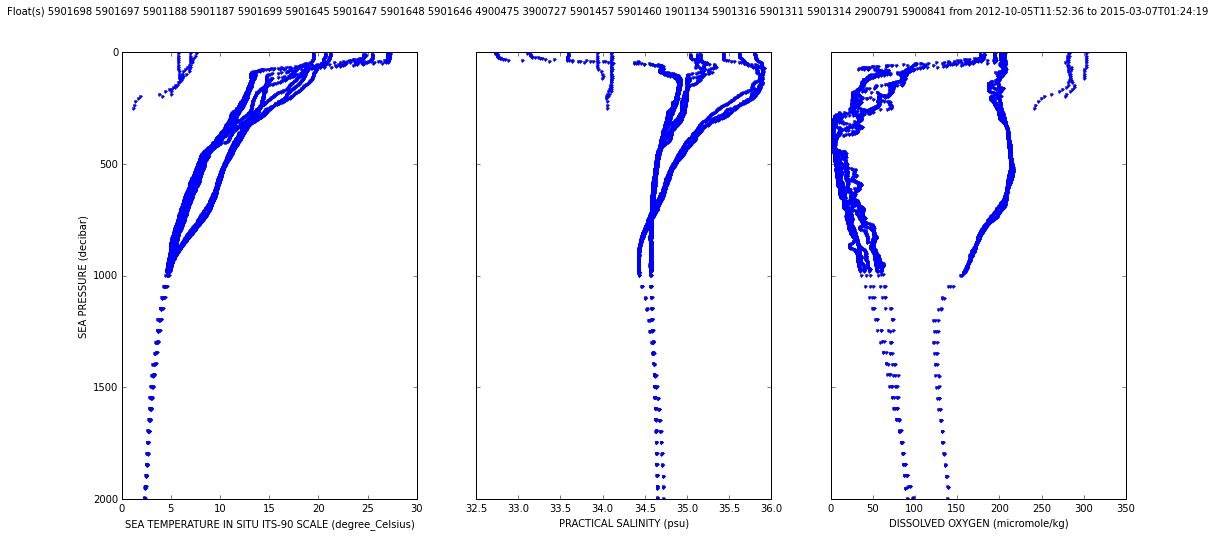

In [7]:
# Parameter long_name and units copied from attributes in NetCDF files
time_range = '{} to {}'.format(df.index.get_level_values('time').min(), 
                               df.index.get_level_values('time').max())
parms = {'TEMP_ADJUSTED': 'SEA TEMPERATURE IN SITU ITS-90 SCALE (degree_Celsius)', 
         'PSAL_ADJUSTED': 'PRACTICAL SALINITY (psu)',
         'DOXY_ADJUSTED': 'DISSOLVED OXYGEN (micromole/kg)'}

plt.rcParams['figure.figsize'] = (18.0, 8.0)
fig, ax = plt.subplots(1, len(parms), sharey=True)
ax[0].invert_yaxis()
ax[0].set_ylabel('SEA PRESSURE (decibar)')

for i, (p, label) in enumerate(parms.iteritems()):
    ax[i].set_xlabel(label)
    ax[i].plot(df[p], df.index.get_level_values('pressure'), '.')
    
plt.suptitle('Float(s) ' + ' '.join(wmo_list) + ' from ' + time_range)

Plot the profiles on a map.

/home/mccann/VirtualEnvs/oxyfloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


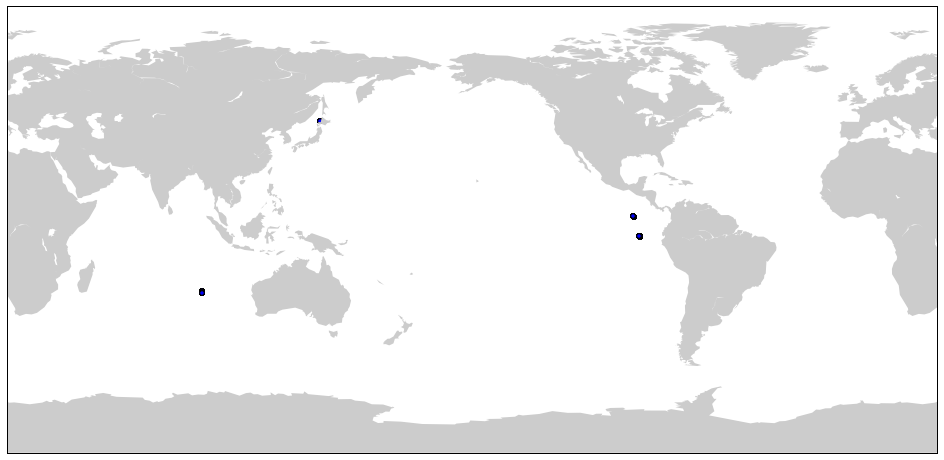

In [8]:
import pylab as plt
from mpl_toolkits.basemap import Basemap

plt.rcParams['figure.figsize'] = (18.0, 8.0)
m = Basemap(llcrnrlon=15, llcrnrlat=-90, urcrnrlon=390, urcrnrlat=90, projection='cyl')
m.fillcontinents(color='0.8')

m.scatter(df.index.get_level_values('lon'), df.index.get_level_values('lat'), latlon=True)